# Introduction

##### Column Information

Each row in the file corresponds to a single player's involvement in a single play. The dataset was intentionally joined (i.e. denormalized) to make the API simple. All the columns are contained in one large dataframe which is grouped and provided by PlayId.

- GameId: a unique game identifier
- PlayId: a unique play identifier
- Team: home or away
- X: player position along the long axis of the field. See figure below.
- Y: player position along the short axis of the field. See figure below.
- S: speed in yards/second
- A: acceleration in yards/second^2
- Dis: distance traveled from prior time point, in yards
- Orientation: orientation of player (deg)
- Dir: angle of player motion (deg)
- NflId: a unique identifier of the player
- DisplayName: player's name
- JerseyNumber: jersey number
- Season: year of the season
- YardLine: the yard line of the line of scrimmage
- Quarter: game quarter (1-5, 5 == overtime)
- GameClock: time on the game clock
- PossessionTeam: team with possession
- Down: the down (1-4)
- Distance: yards needed for a first down
- FieldPosition: which side of the field the play is happening on
- HomeScoreBeforePlay: home team score before play started
- VisitorScoreBeforePlay: visitor team score before play started
- NflIdRusher: the NflId of the rushing player
- OffenseFormation: offense formation
- OffensePersonnel: offensive team positional grouping
- DefendersInTheBox: number of defenders lined up near the line of scrimmage, spanning the width of the offensive line
- DefensePersonnel: defensive team positional grouping
- PlayDirection: direction the play is headed
- TimeHandoff: UTC time of the handoff
- TimeSnap: UTC time of the snap
- Yards: the yardage gained on the play (you are predicting this)
- PlayerHeight: player height (ft-in)
- PlayerWeight: player weight (lbs)
- PlayerBirthDate: birth date (mm/dd/yyyy)
- PlayerCollegeName: where the player attended college
- Position: the player's position (the specific role on the field that they typically play)
- HomeTeamAbbr: home team abbreviation
- VisitorTeamAbbr: visitor team abbreviation
- Week: week into the season
- Stadium: stadium where the game is being played
- Location: city where the game is being played
- StadiumType: description of the stadium environment
- Turf: description of the field surface
- GameWeather: description of the game weather
- Temperature: temperature (deg F)
- Humidity: humidity
- WindSpeed: wind speed in miles/hour
- WindDirection: wind direction

### Libraries

In [152]:
import pandas as pd
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
import scipy.spatial
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import sys
from sklearn.impute import SimpleImputer
from tensorflow.keras.layers import Dense,Input,Dropout, InputLayer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
import keras
from tensorflow.keras.losses import categorical_crossentropy
pd.set_option("display.max_columns", None)

### Exploratory Analysis/Feature Engineering

In [217]:
train = pd.read_csv('train.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [218]:
train.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

We can remove a few columns that we're pretty confident that won't have a significant impact in our prediction as this will help speed things up. 
- PlayerCollegeName: College of player shouldn't have any significant impact in determining how many yards a person will run. Even though certain colleges have better players, a better way to determine how many yards a person will carry is their performance prior to that game or season.
- Stadium and Location: Since StadiumType, Turf, GameWeather, etc. are already included in our study, then stadium and location won't provide any more input as the type of stadium/location is more significant than its name.
- JerseyNumber: Completely useless lol

In [219]:
train = train.drop(['PlayerCollegeName', 'Stadium', 'Location', 'JerseyNumber'], axis = 1)

In [220]:
train[train['FieldPosition'].isnull()]['GameId'].nunique()

296

Some notes to include on feature engineering:
- Added Date of Game (GameId provides this but I preferred a separate column using datetime)
- Added Age of Player (Running backs are known to be in their primes earlier in their careers compared to other positions so age might be a significant predictor)
- Added Minute of Quarter (I felt like specific times were a little bit too granular but I also didn't want to divide up the column into halves or quarters, hence I just stuck with keeping the minute when that play occurred)
- Added Distance of Player to the runner (If more defenders are played close up to line of scrimmage, then that could mean less yards than usual as there is a higher emphasis to stop the run)
- Standardize player tracking coordinates so that offensive units are moving in the same direction throughout the entirety of the game and removed those non-standardized columns
- Added TeamOnOffense, IsOnOffense, and IsBallCarrier as it was difficult to determine which player was on offense or defense and which player was ball carier
- One of the biggest things we want to understand is how much space a player has. So I used a voronoi diagram and its area.

In [221]:
train['Date of Game'] = pd.to_datetime(train['GameId'].astype(str).str[:8])
train['Age of Player'] = np.floor((train['Date of Game'] - pd.to_datetime(train['PlayerBirthDate'])) / np.timedelta64(1, 'Y')).astype(int)
train['Minute of Quarter'] = train['GameClock'].str[:2]

In [222]:
train = train.drop(['PlayerBirthDate'], axis = 1)

##### Standardize player tracking coordinates so that offensive units are moving in the same direction throughout the entirety of the game 
- Credit goes to Michael Lopez (https://www.kaggle.com/statsbymichaellopez/nfl-tracking-wrangling-voronoi-and-sonars) and CPMP (https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python) for having the code to let me do this 

In [223]:
train['ToLeft'] = train.PlayDirection == "left"
train['IsBallCarrier'] = train.NflId == train.NflIdRusher

train.loc[train.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
train.loc[train.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

train.loc[train.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
train.loc[train.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

train.loc[train.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
train.loc[train.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

train.loc[train.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
train.loc[train.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"

train['Dir_rad'] = np.mod(90 - train.Dir, 360) * math.pi/180.0

train['TeamOnOffense'] = "home"
train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"
train['IsOnOffense'] = train.Team == train.TeamOnOffense 
train['YardLine_std'] = 100 - train.YardLine
train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine_std'
         ] = train.loc[train.FieldPosition.fillna('') == train.PossessionTeam,  
          'YardLine']
train['X_std'] = train.X
train.loc[train.ToLeft, 'X_std'] = 120 - train.loc[train.ToLeft, 'X'] 
train['Y_std'] = train.Y
train.loc[train.ToLeft, 'Y_std'] = 160/3 - train.loc[train.ToLeft, 'Y'] 
train['Dir_std'] = train.Dir_rad
train.loc[train.ToLeft, 'Dir_std'] = np.mod(np.pi + train.loc[train.ToLeft, 'Dir_rad'], 2*np.pi)

train.loc[train.Season >= 2018, 'Orientation_rad'
         ] = np.mod(train.loc[train.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0

train['Orientation_rad'] = np.mod(train.Orientation, 360) * math.pi/180.0
train.loc[train.Season >= 2018, 'Orientation_rad'
         ] = np.mod(train.loc[train.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0
train['Orientation_std'] = train.Orientation_rad
train.loc[train.ToLeft, 'Orientation_std'] = np.mod(np.pi + train.loc[train.ToLeft, 'Orientation_rad'], 2*np.pi)
train.loc[train[['PlayId','X_std', 'Y_std']].duplicated(keep = False) == True, 'X_std'] += np.random.uniform(-0.005, 0.005, train[train[['PlayId','X_std', 'Y_std']].duplicated(keep = False)].shape[0])

In [224]:
train = train.drop(['X', 'Y', 'Dir', 'Orientation', 'YardLine'], axis = 1)

##### Add columns with difference between TimeHandoff and TimeSnap

In [225]:
train['TimeDiff'] = (pd.to_datetime(train['TimeHandoff']) - pd.to_datetime(train['TimeSnap'])).dt.seconds.astype(int)

In [226]:
train = train.drop(['TimeHandoff', 'TimeSnap'], axis = 1)

##### Update StadiumType columns (only Indoor - Open, Indoor - Closed or Outdoor)

In [227]:
stadium_type_map = {'Outdoor': 'Outdoors',
                    'Outdoors': 'Outdoors',
                    'Indoors': 'Indoors - Closed',
                    'Retractable Roof': 'Indoors - Closed',
                    'Indoor': 'Indoors - Closed',
                    'Retr. Roof-Closed': 'Indoors - Closed',
                    'Open': 'Outdoors',
                    'Indoor, Open Roof': 'Indoors - Open',
                    'Retr. Roof - Closed': 'Indoors - Closed',
                    'Outddors': 'Outdoors',
                    'Dome': 'Indoors - Closed',
                    'Domed, closed': 'Indoors - Closed',
                    'Outdoor Retr Roof-Open': 'Outdoors',
                    'Closed Dome': 'Indoors - Closed',
                    'Oudoor': 'Outdoors',
                    'Ourdoor': 'Outdoors',
                    'Dome, closed': 'Indoors - Closed',
                    'Retr. Roof-Open': 'Indoors - Open',
                    'Heinz Field': 'Outdoors',
                    'Outdor': 'Outdoors',
                    'Retr. Roof - Open': 'Indoors - Open',
                    'Domed, Open': 'Indoors - Open',
                    'Domed, open': 'Indoors - Open',
                    'Cloudy': 'Indoors - Open',
                    'Bowl': 'Indoors - Closed',
                    'Outside': 'Outdoors',
                    'Domed': 'Indoors - Closed',
                    'Indoor, roof open': 'Indoors - Open',
                    'indoor': 'Indoors - Closed',
                    'Retractable Roof - Closed': 'Indoors - Closed',
                    'OUTDOOR': 'Outdoors'}

In [228]:
train['StadiumType'] = train['StadiumType'].map(stadium_type_map)

In [229]:
# NYG
train.loc[(train[train['StadiumType'].isnull()].index & \
            (train[train['HomeTeamAbbr'] == 'NYG'].index)), 'StadiumType'] = 'Outdoors'

# LAC
train.loc[(train[train['StadiumType'].isnull()].index & \
            (train[train['HomeTeamAbbr'] == 'LAC'].index)), 'StadiumType'] = 'Outdoors'

# IND
train.loc[(train[train['StadiumType'].isnull()].index & \
            (train[train['HomeTeamAbbr'] == 'IND'].index)), 'StadiumType'] = 'Indoors - Closed'

# ATL
train.loc[(train[train['StadiumType'].isnull()].index & \
            (train[train['HomeTeamAbbr'] == 'ATL'].index)), 'StadiumType'] = 'Indoors - Closed'

# JAX
train.loc[(train[train['StadiumType'].isnull()].index & \
            (train[train['HomeTeamAbbr'] == 'JAX'].index)), 'StadiumType'] = 'Outdoors'

##### Update Turf columns (only Natural and Artificial)

In [230]:
turf_map = {'Grass': 'Natural',
            'Natural Grass': 'Natural',
            'Field Turf': 'Artificial',
            'Artificial': 'Artificial',
            'FieldTurf': 'Artificial',
            'UBU Speed Series-S5-M': 'Artificial',
            'A-Turf Titan': 'Artificial',
            'SISGrass': 'Natural',
            'Natural grass': 'Natural',
            'UBU Sports Speed S5-M': 'Artificial',
            'FieldTurf360': 'Artificial',
            'DD GrassMaster': 'Natural',
            'Twenty-Four/Seven Turf': 'Artificial',
            'Artifical': 'Artificial',
            'FieldTurf 360': 'Artificial',
            'Twenty Four/Seven Turf': 'Artificial',
            'Turf': 'Artificial',
            'Natural': 'Natural',
            'Field turf': 'Artificial',
            'Naturall Grass': 'Natural',
            'UBU-Speed Series-S5-M': 'Artificial',
            'natural grass': 'Natural',
            'grass': 'Natural'}

In [231]:
train['Turf'] = train['Turf'].map(turf_map)

##### Update Weather column (only Raiyn, Cloudy, Sunny, Snow, NA)

In [232]:
rainy = ['Rainy', 'Rain Chance 40%', 'Showers',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain', 'Rain likely, temps in low 40s.',
         'Cloudy, 50% change of rain', 'Rain and Wind', 'Raining', 'Cloudy with showers and wind',
        'Light rain']

cloudy = ['Party Cloudy', 'Cloudy, chance of rain',
          'Coudy', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
          'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
          'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
          'Partly Cloudy', 'Cloudy', 'partly cloudy', 'Breezy', 'overcast', 'Partly cloudy and mild']

sunny = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
           'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
           'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
           'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
           'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
           'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny', 'Mostly Clear', 'Mostly clear',
          'sUNNY', 'Sunny, Windy']

snow = ['Heavy lake effect snow', 'Snow', 'Cloudy, light snow accumulating 1-3', 'Cloudy, light snow accumulating 1-3"']

na = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate', 'N/A Indoors']

weather_map = dict()

for lst, name in zip([rainy, cloudy, sunny, snow, na], ['Rainy', 'Cloudy', 'Clear', 'Snow', 'NA']):
    for item in lst:
        weather_map[item] = name

In [233]:
train['GameWeather'] = train['GameWeather'].map(weather_map)

In [234]:
train.loc[(train[train['GameWeather'].isnull()].index), 'GameWeather'] = 'NA'

##### Update WindSpeed column

In [235]:
train['WindSpeed'] = train['WindSpeed'].astype(str).str.split('.').str[0].str.extract('(\d+)')

##### Updated WindDirection column

In [236]:
SW = ['SW', 'WSW', 'SSW', 'South', 'Southwest', 'SouthWest', 'West-Southwest', 'S-SW', 'From NNE', 'W-SW', 'From NE',
      'South Southwest', 'South west']
NE = ['NE', 'NNE', 'ENE', 'From SW', 'Northeast', 'NorthEast', 'North East', 'N-NE', 'From SSW', 'From WSW',
      'East North East']
NW = ['NW', 'WNW', 'NNW', 'Northwest', 'W-NW', 'West Northwest', 'North/Northwest', 'From SSE', 'From ESE']
SE = ['SE', 'SSE', 'East Southeast', 'ESE', 'Southeast', 'South, Southeast', 'East Southeast', 'South Southeast',
      'From NNW']
N = ['N', 'North', 'From S', '1', '13']
W = ['W', 'West', '8']
S = ['S', 'South', 's', 'Southerly']
E = ['E', 'East', 'From W', 'EAST', 'from W']

wind_dir_map = dict()

for lst, name in zip([SW, NE, NW, SE, N, W, S, E], ['SW', 'NE', 'NW', 'SE', 'N', 'W', 'S', 'E']):
    for item in lst:
        wind_dir_map[item] = name

In [237]:
train['WindDirection'] = train['WindDirection'].map(wind_dir_map)

In [238]:
train.loc[(train[train['WindDirection'].isnull()].index), 'WindDirection'] = 'NA'

##### Add feature to determine distance of player from runner  in terms of yards

In [239]:
train = train.merge(train[train['IsBallCarrier'] == True][['PlayId', 'X_std', 'Y_std']].rename(columns = {'X_std': 'Runner_X_std',
                                                                                      'Y_std': 'Runner_Y_std'}),
             on = 'PlayId',
             how = 'left')

train['Distance_From_Runner'] = np.sqrt((train['X_std'] - train['Runner_X_std'])**2 + (train['Y_std'] - train['Runner_Y_std'])**2)
train = train.drop(['Runner_X_std', 'Runner_Y_std'], axis = 1)

##### Difference in Score column

In [240]:
train['DifferenceInScore'] = train.apply(lambda x: (x['HomeScoreBeforePlay'] - x['VisitorScoreBeforePlay']) if x['TeamOnOffense'] == 'home' else (x['VisitorScoreBeforePlay'] - x['HomeScoreBeforePlay']), axis = 1)

##### Count of Offensive/Defensive Personnel

In [241]:
def personel_count(string, position):
    
    list_split = string.split(position)
    
    if len(list_split) == 1:
        return(0)
    else:
        return(int(list_split[0][-2]))
    
# Fix this specific play with wrong formation
train.loc[train['DefensePersonnel'] == '4 DL, 3 LB, 5 DB', 'DefensePersonnel'] = '4 DL, 2 LB, 5 DB'

# Offense Categories 
for pos in ['RB', 'WR', 'OL', 'QB', 'TE']:

    train['{} Count'.format(pos)] = train['OffensePersonnel'].apply(lambda x: personel_count(x, pos))
    
# Defense Categories
for pos in ['DL', 'DB', 'LB']:

    train['{} Count'.format(pos)] = train['DefensePersonnel'].apply(lambda x: personel_count(x, pos))
    
train.loc[train['OL Count'] == 0, 'OL Count'] = 5
train.loc[train['QB Count'] == 0, 'QB Count'] = 1

train['Total Count (Offense)'] = train['RB Count'] + train['WR Count'] + train['OL Count'] + train['QB Count'] + train['TE Count']
train['Total Count (Defense)'] = train['DL Count'] + train['DB Count'] + train['LB Count']

train.loc[train['Total Count (Offense)'] == 10, 'OL Count'] += 1
train.loc[train['Total Count (Offense)'] == 9, 'OL Count'] += 2
train.loc[train['Total Count (Defense)'] == 10, 'DL Count'] += 1

train = train.drop(['OffensePersonnel', 'DefensePersonnel', 'Total Count (Offense)', 'Total Count (Defense)'], axis = 1)

##### Add feature to determine how much space between defenders

In [242]:
# Code was used from https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

# Code influenced by this link (https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells) to get the areas of a voronoi diagram by bounding the plane
def voronoi_test(df):
    
    eps = sys.float_info.epsilon
    
    num_regions = 0
    value = 0
    
    while num_regions < 22:
    
        towers = np.array(df[['X_std', 'Y_std']])
        bounding_box = np.array([df['X_std'].min()-(value), df['X_std'].max()+(value)+0.001, df['Y_std'].min()-(value) , df['Y_std'].max()+(value)])

        points_center = towers.copy()
        points_left = np.copy(points_center)
        points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
        points_right = np.copy(points_center)
        points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
        points_down = np.copy(points_center)
        points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
        points_up = np.copy(points_center)
        points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
        points = np.append(points_center,
                           np.append(np.append(points_left,
                                               points_right,
                                               axis=0),
                                     np.append(points_down,
                                               points_up,
                                               axis=0),
                                     axis=0),
                           axis=0)

        # Compute Voronoi
        vor = scipy.spatial.Voronoi(points)

        # Filter regions
        regions = []
        for region in vor.regions:
            flag = True
            for index in region:
                if index == -1:
                    flag = False
                    break
                else:
                    x = vor.vertices[index, 0]
                    y = vor.vertices[index, 1]
                    if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                           bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                        flag = False
                        break
            if region != [] and flag:
                regions.append(region)
                
        num_regions = len(regions)
        value += 0.001
    
    vor.filtered_points = points_center
    vor.filtered_regions = regions

    area_values = []
    for index in vor.point_region[:22]:
        vertices_df = pd.DataFrame(vor.vertices[vor.regions[index],:]).rename(columns = {0: 'x',
                                                                                1: 'y'})
        area_values.append(PolyArea(vertices_df.x, vertices_df.y))
    
    return(pd.Series(area_values))

In [31]:
%%time
train['Area of Space'] = train.groupby('PlayId').apply(lambda x: voronoi_test(x)).reset_index().melt(id_vars = 'PlayId').sort_values(['PlayId', 'variable'])[['value']].reset_index(drop = True)

CPU times: user 13min 50s, sys: 5.69 s, total: 13min 56s
Wall time: 14min 46s


# Final Code

In [32]:
train = pd.read_csv('train.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
def personel_count(string, position):
    
    list_split = string.split(position)
    
    if len(list_split) == 1:
        return(0)
    else:
        return(int(list_split[0][-2]))
    
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def voronoi_test(df):
    
    eps = sys.float_info.epsilon
    
    num_regions = 0
    value = 0
    
    while num_regions < 22:
    
        towers = np.array(df[['X_std', 'Y_std']])
        bounding_box = np.array([df['X_std'].min()-(value), df['X_std'].max()+(value)+0.001, df['Y_std'].min()-(value) , df['Y_std'].max()+(value)])

        points_center = towers.copy()
        points_left = np.copy(points_center)
        points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
        points_right = np.copy(points_center)
        points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
        points_down = np.copy(points_center)
        points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
        points_up = np.copy(points_center)
        points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
        points = np.append(points_center,
                           np.append(np.append(points_left,
                                               points_right,
                                               axis=0),
                                     np.append(points_down,
                                               points_up,
                                               axis=0),
                                     axis=0),
                           axis=0)

        # Compute Voronoi
        vor = scipy.spatial.Voronoi(points)

        # Filter regions
        regions = []
        for region in vor.regions:
            flag = True
            for index in region:
                if index == -1:
                    flag = False
                    break
                else:
                    x = vor.vertices[index, 0]
                    y = vor.vertices[index, 1]
                    if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                           bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                        flag = False
                        break
            if region != [] and flag:
                regions.append(region)
                
        num_regions = len(regions)
        value += 0.001
    
    vor.filtered_points = points_center
    vor.filtered_regions = regions

    area_values = []
    for index in vor.point_region[:22]:
        vertices_df = pd.DataFrame(vor.vertices[vor.regions[index],:]).rename(columns = {0: 'x',
                                                                                1: 'y'})
        area_values.append(PolyArea(vertices_df.x, vertices_df.y))
    
    return(pd.Series(area_values))

def final_data(df):
    
    df_copy = df.copy()
   
    # === Adding in Date of Game/Age of Player/Minute === 
    df_copy['Date of Game'] = pd.to_datetime(df_copy['GameId'].astype(str).str[:8])
    df_copy['Age of Player'] = np.floor((df_copy['Date of Game'] - pd.to_datetime(df_copy['PlayerBirthDate'])) / np.timedelta64(1, 'Y')).astype(int)
    df_copy['Minute of Quarter'] = df_copy['GameClock'].str[:2]
    df_copy['PlayerHeight'] = df_copy['PlayerHeight'].str.split('-').str[0].astype(int)*12 + train['PlayerHeight'].str.split('-').str[1].astype(int)
    
    # === Standardize player tracking coordinates === 
    df_copy['ToLeft'] = df_copy.PlayDirection == "left"
    df_copy['IsBallCarrier'] = df_copy.NflId == df_copy.NflIdRusher

    df_copy.loc[df_copy.VisitorTeamAbbr == "ARI", 'VisitorTeamAbbr'] = "ARZ"
    df_copy.loc[df_copy.HomeTeamAbbr == "ARI", 'HomeTeamAbbr'] = "ARZ"

    df_copy.loc[df_copy.VisitorTeamAbbr == "BAL", 'VisitorTeamAbbr'] = "BLT"
    df_copy.loc[df_copy.HomeTeamAbbr == "BAL", 'HomeTeamAbbr'] = "BLT"

    df_copy.loc[df_copy.VisitorTeamAbbr == "CLE", 'VisitorTeamAbbr'] = "CLV"
    df_copy.loc[df_copy.HomeTeamAbbr == "CLE", 'HomeTeamAbbr'] = "CLV"

    df_copy.loc[df_copy.VisitorTeamAbbr == "HOU", 'VisitorTeamAbbr'] = "HST"
    df_copy.loc[df_copy.HomeTeamAbbr == "HOU", 'HomeTeamAbbr'] = "HST"

    df_copy['Dir_rad'] = np.mod(90 - df_copy.Dir, 360) * math.pi/180.0

    df_copy['TeamOnOffense'] = "home"
    df_copy.loc[df_copy.PossessionTeam != df_copy.HomeTeamAbbr, 'TeamOnOffense'] = "away"
    df_copy['IsOnOffense'] = df_copy.Team == df_copy.TeamOnOffense 
    df_copy['YardLine_std'] = 100 - df_copy.YardLine
    df_copy.loc[df_copy.FieldPosition.fillna('') == df_copy.PossessionTeam,  
              'YardLine_std'
             ] = df_copy.loc[df_copy.FieldPosition.fillna('') == df_copy.PossessionTeam,  
              'YardLine']
    df_copy['X_std'] = df_copy.X
    df_copy.loc[df_copy.ToLeft, 'X_std'] = 120 - df_copy.loc[df_copy.ToLeft, 'X'] 
    df_copy['Y_std'] = df_copy.Y
    df_copy.loc[df_copy.ToLeft, 'Y_std'] = 160/3 - df_copy.loc[df_copy.ToLeft, 'Y'] 
    df_copy['Dir_std'] = df_copy.Dir_rad
    df_copy.loc[df_copy.ToLeft, 'Dir_std'] = np.mod(np.pi + df_copy.loc[df_copy.ToLeft, 'Dir_rad'], 2*np.pi)

    df_copy.loc[df_copy.Season >= 2018, 'Orientation_rad'
             ] = np.mod(df_copy.loc[df_copy.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0

    df_copy['Orientation_rad'] = np.mod(df_copy.Orientation, 360) * math.pi/180.0
    df_copy.loc[df_copy.Season >= 2018, 'Orientation_rad'
             ] = np.mod(df_copy.loc[df_copy.Season >= 2018, 'Orientation'] - 90, 360) * math.pi/180.0
    df_copy['Orientation_std'] = df_copy.Orientation_rad
    df_copy.loc[df_copy.ToLeft, 'Orientation_std'] = np.mod(np.pi + df_copy.loc[df_copy.ToLeft, 'Orientation_rad'], 2*np.pi)
    df_copy.loc[df_copy[['PlayId','X_std', 'Y_std']].duplicated(keep = False) == True, 'X_std'] += np.random.uniform(-0.005, 0.005, df_copy[df_copy[['PlayId','X_std', 'Y_std']].duplicated(keep = False)].shape[0])
    
    # === Add columns with difference between TimeHandoff and TimeSnap === 
    df_copy['TimeDiff'] = (pd.to_datetime(df_copy['TimeHandoff']) - pd.to_datetime(df_copy['TimeSnap'])).dt.seconds.astype(int)
    
    # === Update StadiumType columns (only Indoor - Open, Indoor - Closed or Outdoor) ===
    stadium_type_map = {'Outdoor': 'Outdoors',
                    'Outdoors': 'Outdoors',
                    'Indoors': 'Indoors - Closed',
                    'Retractable Roof': 'Indoors - Closed',
                    'Indoor': 'Indoors - Closed',
                    'Retr. Roof-Closed': 'Indoors - Closed',
                    'Open': 'Outdoors',
                    'Indoor, Open Roof': 'Indoors - Open',
                    'Retr. Roof - Closed': 'Indoors - Closed',
                    'Outddors': 'Outdoors',
                    'Dome': 'Indoors - Closed',
                    'Domed, closed': 'Indoors - Closed',
                    'Outdoor Retr Roof-Open': 'Outdoors',
                    'Closed Dome': 'Indoors - Closed',
                    'Oudoor': 'Outdoors',
                    'Ourdoor': 'Outdoors',
                    'Dome, closed': 'Indoors - Closed',
                    'Retr. Roof-Open': 'Indoors - Open',
                    'Heinz Field': 'Outdoors',
                    'Outdor': 'Outdoors',
                    'Retr. Roof - Open': 'Indoors - Open',
                    'Domed, Open': 'Indoors - Open',
                    'Domed, open': 'Indoors - Open',
                    'Cloudy': 'Indoors - Open',
                    'Bowl': 'Indoors - Closed',
                    'Outside': 'Outdoors',
                    'Domed': 'Indoors - Closed',
                    'Indoor, roof open': 'Indoors - Open',
                    'indoor': 'Indoors - Closed',
                    'Retractable Roof - Closed': 'Indoors - Closed',
                    'OUTDOOR': 'Outdoors'}
    
    df_copy['StadiumType'] = df_copy['StadiumType'].map(stadium_type_map)
    df_copy.loc[(df_copy[df_copy['StadiumType'].isnull()].index & \
                (df_copy[df_copy['HomeTeamAbbr'] == 'NYG'].index)), 'StadiumType'] = 'Outdoors'
    df_copy.loc[(df_copy[df_copy['StadiumType'].isnull()].index & \
                (df_copy[df_copy['HomeTeamAbbr'] == 'LAC'].index)), 'StadiumType'] = 'Outdoors'
    df_copy.loc[(df_copy[df_copy['StadiumType'].isnull()].index & \
                (df_copy[df_copy['HomeTeamAbbr'] == 'IND'].index)), 'StadiumType'] = 'Indoors - Closed'
    df_copy.loc[(df_copy[df_copy['StadiumType'].isnull()].index & \
                (df_copy[df_copy['HomeTeamAbbr'] == 'ATL'].index)), 'StadiumType'] = 'Indoors - Closed'
    df_copy.loc[(df_copy[df_copy['StadiumType'].isnull()].index & \
                (df_copy[df_copy['HomeTeamAbbr'] == 'JAX'].index)), 'StadiumType'] = 'Outdoors'
    
    # === Update Turf columns (only Natural and Artificial) === 
    turf_map = {'Grass': 'Natural',
            'Natural Grass': 'Natural',
            'Field Turf': 'Artificial',
            'Artificial': 'Artificial',
            'FieldTurf': 'Artificial',
            'UBU Speed Series-S5-M': 'Artificial',
            'A-Turf Titan': 'Artificial',
            'SISGrass': 'Natural',
            'Natural grass': 'Natural',
            'UBU Sports Speed S5-M': 'Artificial',
            'FieldTurf360': 'Artificial',
            'DD GrassMaster': 'Natural',
            'Twenty-Four/Seven Turf': 'Artificial',
            'Artifical': 'Artificial',
            'FieldTurf 360': 'Artificial',
            'Twenty Four/Seven Turf': 'Artificial',
            'Turf': 'Artificial',
            'Natural': 'Natural',
            'Field turf': 'Artificial',
            'Naturall Grass': 'Natural',
            'UBU-Speed Series-S5-M': 'Artificial',
            'natural grass': 'Natural',
            'grass': 'Natural'}
    
    df_copy['Turf'] = df_copy['Turf'].map(turf_map)
    
    # === Update Weather column (only Raiyn, Cloudy, Sunny, Snow, NA) ===
    rainy = ['Rainy', 'Rain Chance 40%', 'Showers',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain', 'Rain likely, temps in low 40s.',
         'Cloudy, 50% change of rain', 'Rain and Wind', 'Raining', 'Cloudy with showers and wind',
        'Light rain']

    cloudy = ['Party Cloudy', 'Cloudy, chance of rain',
              'Coudy', 'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
              'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
              'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
              'Partly Cloudy', 'Cloudy', 'partly cloudy', 'Breezy', 'overcast', 'Partly cloudy and mild']

    sunny = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
               'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
               'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
               'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
               'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
               'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny', 'Mostly Clear', 'Mostly clear',
              'sUNNY', 'Sunny, Windy']

    snow = ['Heavy lake effect snow', 'Snow', 'Cloudy, light snow accumulating 1-3', 'Cloudy, light snow accumulating 1-3"']

    na = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate', 'N/A Indoors']

    weather_map = dict()

    for lst, name in zip([rainy, cloudy, sunny, snow, na], ['Rainy', 'Cloudy', 'Clear', 'Snow', 'NA']):
        for item in lst:
            weather_map[item] = name
            
    df_copy['GameWeather'] = df_copy['GameWeather'].map(weather_map)
    
    df_copy.loc[(df_copy[df_copy['GameWeather'].isnull()].index), 'GameWeather'] = 'NA'

    # === Update WindSpeed column ===
    df_copy['WindSpeed'] = df_copy['WindSpeed'].astype(str).str.split('.').str[0].str.extract('(\d+)')
    
    # === Add feature to determine distance of player from runner in terms of yards ===
    df_copy = df_copy.merge(df_copy[df_copy['IsBallCarrier'] == True][['PlayId', 'X_std', 'Y_std']].rename(columns = {'X_std': 'Runner_X_std',
                                                                                      'Y_std': 'Runner_Y_std'}),
             on = 'PlayId',
             how = 'left')

    df_copy['Distance_From_Runner'] = np.sqrt((df_copy['X_std'] - df_copy['Runner_X_std'])**2 + (df_copy['Y_std'] - df_copy['Runner_Y_std'])**2)
    distance_from_runner = df_copy[df_copy['IsOnOffense'] == False].groupby(['PlayId']).quantile([0, 0.25, 0.5, 0.75, 1])['Distance_From_Runner'].reset_index().pivot(index = 'PlayId', columns = 'level_1').reset_index()
    distance_from_runner.columns = ['PlayId', 'Distance_From_Runner_Min', 'Distance_From_Runner_25', 'Distance_From_Runner_50', 'Distance_From_Runner_75', 'Distance_From_Runner_Max']

    # === Difference in Score column === 
    df_copy['DifferenceInScore'] = df_copy.apply(lambda x: (x['HomeScoreBeforePlay'] - x['VisitorScoreBeforePlay']) if x['TeamOnOffense'] == 'home' else (x['VisitorScoreBeforePlay'] - x['HomeScoreBeforePlay']), axis = 1)
    
    
    # === Count of Offensive/Defensive Personnel === 
    # Fix this specific play with wrong formation
    df_copy.loc[df_copy['DefensePersonnel'] == '4 DL, 3 LB, 5 DB', 'DefensePersonnel'] = '4 DL, 2 LB, 5 DB'

    # Offense Categories 
    for pos in ['RB', 'WR', 'OL', 'QB', 'TE']:

        df_copy['{} Count'.format(pos)] = df_copy['OffensePersonnel'].apply(lambda x: personel_count(x, pos))

    # Defense Categories
    for pos in ['DL', 'DB', 'LB']:

        df_copy['{} Count'.format(pos)] = df_copy['DefensePersonnel'].apply(lambda x: personel_count(x, pos))

    df_copy.loc[df_copy['OL Count'] == 0, 'OL Count'] = 5
    df_copy.loc[df_copy['QB Count'] == 0, 'QB Count'] = 1

    df_copy['Total Count (Offense)'] = df_copy['RB Count'] + df_copy['WR Count'] + df_copy['OL Count'] + df_copy['QB Count'] + df_copy['TE Count']
    df_copy['Total Count (Defense)'] = df_copy['DL Count'] + df_copy['DB Count'] + df_copy['LB Count']

    df_copy.loc[df_copy['Total Count (Offense)'] == 10, 'OL Count'] += 1
    df_copy.loc[df_copy['Total Count (Offense)'] == 9, 'OL Count'] += 2
    df_copy.loc[df_copy['Total Count (Defense)'] == 10, 'DL Count'] += 1
    
    # Fix FieldPosition is null
    df_copy.loc[(ex['FieldPosition'].isnull()),'FieldPosition'] = df_copy.loc[(ex['FieldPosition'].isnull()),'PossessionTeam']

    # === Add feature to determine how much space between defenders ===
    df_copy['Area of Space'] = df_copy.groupby('PlayId').apply(lambda x: voronoi_test(x)).reset_index().melt(id_vars = 'PlayId').sort_values(['PlayId', 'variable'])[['value']].reset_index(drop = True)
    defense_area = df_copy[df_copy['IsOnOffense'] == False].groupby(['PlayId']).quantile([0, 0.25, 0.5, 0.75, 1])['Area of Space'].reset_index().pivot(index = 'PlayId', columns = 'level_1').reset_index()
    defense_area.columns = ['PlayId', 'Area_of_Space_Min', 'Area_of_Space_25', 'Area_of_Space_50', 'Area_of_Space_75', 'Area_of_Space_Max']
    
    # === Creating final dataset for each play ===
    final_df_copy = df_copy[df_copy['IsBallCarrier'] == True][['PlayId','Down', 'Dis', 'Distance', 'OffenseFormation', 'DefendersInTheBox', 'Yards', 'PlayerHeight', 'S', 'A',
                                                'PlayerWeight', 'StadiumType', 'Turf', 'GameWeather', 'Temperature',
                                                'Humidity', 'WindSpeed', 'WindDirection', 'Age of Player', 'Minute of Quarter',
                                                'X_std', 'Y_std', 'Dir_std', 'Orientation_std', 'TimeDiff', 'DifferenceInScore',
                                                'RB Count', 'WR Count', 'OL Count', 'QB Count', 'TE Count', 'DB Count', 'Area of Space']]
    final_df_copy = final_df_copy.merge(defense_area,
                              on = 'PlayId',
                              how = 'left')
    final_df_copy = final_df_copy.merge(distance_from_runner,
                              on = 'PlayId',
                              how = 'left')
    
    # === Deal with missing values ===
    for col in final_df_copy.columns:
        if final_df_copy[col].isnull().sum() > 0:
            if final_df_copy[col].dtype == 'O':
                imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
                final_df_copy[col] = imputer.fit_transform(final_df_copy[col].values.reshape(-1,1))[:,0]
            elif (final_df_copy[col].dtype == 'float64') | (final_df_copy[col].dtype == 'int64'):
                imputer = SimpleImputer(missing_values=np.nan, strategy='median')
                final_df_copy[col] = imputer.fit_transform(final_df_copy[col].values.reshape(-1,1))[:,0]
                
    return final_df_copy

In [34]:
final_df = final_data(train)

In [35]:
final_test = final_df.copy()

In [36]:
y = np.zeros((final_test['Yards'].shape[0], 199))
for idx, target in enumerate(list(final_test['Yards'])):
    y[idx][99 + target] = 1

In [39]:
categorical_col = ['OffenseFormation', 'StadiumType', 'Turf', 'GameWeather', 'WindDirection', 'Down']
numerical_col = ['Dis', 'Distance', 'OffenseFormation',
       'DefendersInTheBox', 'PlayerHeight', 'S', 'A', 'PlayerWeight', 'Temperature', 'Humidity',
       'WindSpeed', 'Age of Player', 'Minute of Quarter', 'Yardline_std'
       'X_std', 'Y_std', 'Dir_std', 'Orientation_std', 'TimeDiff',
       'DifferenceInScore', 'RB Count', 'WR Count', 'OL Count', 'QB Count',
       'TE Count', 'DB Count', 'Area of Space', 'Area_of_Space_Min',
       'Area_of_Space_25', 'Area_of_Space_50', 'Area_of_Space_75',
       'Area_of_Space_Max', 'Distance_From_Runner_Min',
       'Distance_From_Runner_25', 'Distance_From_Runner_50',
       'Distance_From_Runner_75', 'Distance_From_Runner_Max']


for cat in categorical_col:
    final_test[cat] = LabelEncoder().fit_transform(final_test[cat])
    
scaled_features = StandardScaler().fit_transform(final_test[numerical_col].values)
X_num = pd.DataFrame(scaled_features, columns = numerical_col)
X_final = pd.concat([X_num, final_test[categorical_col]], axis = 1).to_numpy()

In [40]:
X_train, X_val = X_final[0:26007], X_final[-5000:]
y_train, y_val = y[0:26007], y[-5000:]

In [41]:
# Calculate CRPS score
def crps_score(y_prediction, y_valid, shape):
    y_true = np.clip(np.cumsum(y_valid, axis=1), 0, 1)
    y_pred = np.clip(np.cumsum(y_prediction, axis=1), 0, 1)
    val_s = ((y_true - y_pred) ** 2).sum(axis=1).sum(axis=0) / (199 * shape)
    crps = np.round(val_s, 6)
    
    return crps

### Random Forest

In [43]:
# From https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(5, 30, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = grid, n_iter = 25, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=25,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 11, 17, 23, 30, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 32, 55, 77, 100]},
                   random_state=42, verbose=2)

In [44]:
rf_random.best_params_

{'n_estimators': 77,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': False}

In [272]:
best_rf = RandomForestClassifier(n_estimators = 77, max_depth = 5, min_samples_split = 2, min_samples_leaf = 1,
                                max_features = 'sqrt', bootstrap = False)
best_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=5, max_features='sqrt',
                      n_estimators=77)

In [275]:
y_pred = best_rf.predict(X_train)
rf_crps_train = crps_score(y_pred, y_train, shape=X_train.shape[0])
rf_crps_train

0.013523

In [274]:
y_pred = best_rf.predict(X_val)
rf_crps_test = crps_score(y_pred, y_val, shape=X_val.shape[0])
rf_crps_test

0.013319

### Neural Networks

In [172]:
# Used https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
def create_model(learning_rate, dropout, dense1, dense2):
    
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[0], X_train.shape[1])))
    model.add(Dense(dense1, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(dense2, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(199, activation='softmax'))
    model.compile(loss=categorical_crossentropy,
                  optimizer=Adam(lr=learning_rate),
                  metrics=['acc'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
dense1 = [612, 1224, 2448]
dense2 = [306, 612, 1024]
epochs = [5, 10, 15]
dropout = [0.4, 0.5, 0.6]
learning_rate = [0.01, 0.001, 0.0001]

grid = dict(dense1=dense1, dense2=dense2, epochs=epochs,
                  dropout=dropout, learning_rate=learning_rate)

nn_grid = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3)
nn_result = nn_grid.fit(X_train, y_train)

In [173]:
nn_result.best_params_

{'dense1': 1024,
 'dense2': 612,
 'dropout': 0.5,
 'epochs': 15,
 'learning_rate': 0.001}

In [276]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[0], X_train.shape[1])))
model.add(Dense(1224, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(612, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(306, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(199, activation='softmax'))
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001),
              metrics=['acc'])
model.fit(X_train, y_train,
          batch_size=128,
          epochs=15,
          verbose=1)

Epoch 1/15
204/204 [==============================] - 4s 17ms/step - loss: 3.6562 - acc: 0.1018
Epoch 2/15
204/204 [==============================] - 3s 15ms/step - loss: 2.9576 - acc: 0.1264
Epoch 3/15
204/204 [==============================] - 3s 16ms/step - loss: 2.8990 - acc: 0.1265
Epoch 4/15
204/204 [==============================] - 4s 20ms/step - loss: 2.8650 - acc: 0.1298
Epoch 5/15
204/204 [==============================] - 4s 19ms/step - loss: 2.8563 - acc: 0.1362
Epoch 6/15
204/204 [==============================] - 4s 18ms/step - loss: 2.8308 - acc: 0.1380
Epoch 7/15
204/204 [==============================] - 4s 22ms/step - loss: 2.8293 - acc: 0.1332
Epoch 8/15
204/204 [==============================] - 4s 19ms/step - loss: 2.8165 - acc: 0.1393
Epoch 9/15
204/204 [==============================] - 4s 20ms/step - loss: 2.8022 - acc: 0.1408
Epoch 10/15
204/204 [==============================] - 5s 22ms/step - loss: 2.8062 - acc: 0.1447
Epoch 11/15
204/204 [==================

In [279]:
y_pred = model.predict(X_train)
cnn_crps_train = crps_score(y_pred, y_train, shape=X_train.shape[0])
cnn_crps_train

0.012988

In [280]:
y_pred = model.predict(X_val)
cnn_crps_test = crps_score(y_pred, y_val, shape=X_val.shape[0])
cnn_crps_test

0.013309

### Voronoi Diagram
- This code was influenced by this link (https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells) to get the areas of a voronoi diagram by bounding the plane

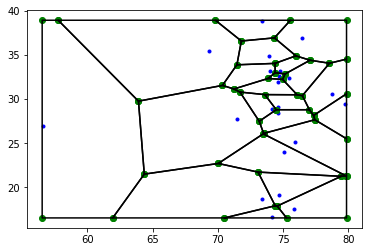

In [185]:
import matplotlib.pyplot as pl
import numpy as np
import scipy as sp
import scipy.spatial
import sys

eps = sys.float_info.epsilon
df = train[train['PlayId'] == 20170907000118]
towers = np.array(df[['X', 'Y']])
value = 0.1
bounding_box = np.array([df['X'].min()-(value), df['X'].max()+(value)+0.001, df['Y'].min()-(value) , df['Y'].max()+(value)])

points_center = towers.copy()
points_left = np.copy(points_center)
points_left[:, 0] = bounding_box[0] - (points_left[:, 0] - bounding_box[0])
points_right = np.copy(points_center)
points_right[:, 0] = bounding_box[1] + (bounding_box[1] - points_right[:, 0])
points_down = np.copy(points_center)
points_down[:, 1] = bounding_box[2] - (points_down[:, 1] - bounding_box[2])
points_up = np.copy(points_center)
points_up[:, 1] = bounding_box[3] + (bounding_box[3] - points_up[:, 1])
points = np.append(points_center,
                   np.append(np.append(points_left,
                                       points_right,
                                       axis=0),
                             np.append(points_down,
                                       points_up,
                                       axis=0),
                             axis=0),
                   axis=0)
# Compute Voronoi
vor = scipy.spatial.Voronoi(points)

# Filter regions
regions = []
for region in vor.regions:
    flag = True
    for index in region:
        if index == -1:
            flag = False
            break
        else:
            x = vor.vertices[index, 0]
            y = vor.vertices[index, 1]
            if not(bounding_box[0] - eps <= x and x <= bounding_box[1] + eps and
                   bounding_box[2] - eps <= y and y <= bounding_box[3] + eps):
                flag = False
                break
    if region != [] and flag:
        regions.append(region)

vor.filtered_points = points_center
vor.filtered_regions = regions

fig = pl.figure()
ax = fig.gca()
# Plot initial points
ax.plot(vor.filtered_points[:, 0], vor.filtered_points[:, 1], 'b.')
# Plot ridges points
for region in vor.filtered_regions:
    vertices = vor.vertices[region, :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'go')
# Plot ridges
for region in vor.filtered_regions:
    vertices = vor.vertices[region + [region[0]], :]
    ax.plot(vertices[:, 0], vertices[:, 1], 'k-')

### References

- https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
- https://stackoverflow.com/questions/28665491/getting-a-bounded-polygon-coordinates-from-voronoi-cells
- https://www.kaggle.com/cpmpml/initial-wrangling-voronoi-areas-in-python
- https://www.kaggle.com/statsbymichaellopez/nfl-tracking-wrangling-voronoi-and-sonars
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/